In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=f4bd452292dfd1b2784971350adb5d6ad76ebea80ef3ab2364e216d20d5f9d45
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.8 MB/s eta 0:00:00


In [ ]:

import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, GlobalAveragePooling2D, Multiply, Dense, Reshape, BatchNormalization, LSTM, Concatenate
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
#if not (os.path.isfile('Indian_pines_corrected.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
#if not (os.path.isfile('Indian_pines_gt.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'SA'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_folder = '/content/drive/MyDrive/yapayZekaSistemleri/dataset'
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_folder, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_folder, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_folder, 'Pavia.mat'))['pavia']
        labels = sio.loadmat(os.path.join(data_folder, 'Pavia_gt.mat'))['pavia_gt']

    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 217, 204), (512, 217))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(512, 217, 15)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((54129, 25, 25, 15), (54129,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((16238, 25, 25, 15), (37891, 25, 25, 15), (16238,), (37891,))

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(16238, 25, 25, 15, 1)

In [ ]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(16238, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
# Giriş katmanı
input_layer = Input((S, S, L, 1))

# 3D Evrişim Katmanları (Spektral özellikler)
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

# Yeniden Şekillendirme
conv3d_shape = conv_layer3.shape
reshaped_layer = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

# Kanal Attention Modülü
attention = GlobalAveragePooling2D()(reshaped_layer)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='sigmoid')(attention)
attention = Reshape((1, 1, 1, 32))(attention)
conv_layer3 = Multiply()([conv_layer3, attention])

# Mekansal özelliklerin işlenmesi için Conv2D katmanı
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

# Tam Bağlantılı Katmanlar
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 25, 15, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 23, 23, 9, 8)         512       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 21, 21, 5, 16)        5776      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 19, 19, 3, 32)        13856     ['conv3d_1[0][0]']            
                                                                                              

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "/content/drive/MyDrive/yapayZekaSistemleri/salinas/2d3dcnn-sa2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time

start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

end_time = time.time()

# Eğitim süresi hesaplanır ve ekrana yazdırılır
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.8003

64/64 [==============================] - 11s 42ms/step - loss: 0.5998 - accuracy: 0.8003
Epoch 2/100
63/64 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9870

64/64 [==============================] - 2s 30ms/step - loss: 0.0433 - accuracy: 0.9871
Epoch 3/100
63/64 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9963

64/64 [==============================] - 2s 30ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 4/100
63/64 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9969

64/64 [==============================] - 2s 30ms/step - loss: 0.0107 - accuracy: 0.9969
Epoch 5/100
63/64 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

64/64 [==============================] - 2s 30ms/step - loss: 0.0071 - accuracy: 0.9980
Epoch 6/100
63/64 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9975

64/64 [==============================] - 2s 30ms/step - loss: 0.0096 - accuracy: 0.9975
Epoch 7/100
63/64 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9956

64/64 [==============================] - 2s 30ms/step - loss: 0.0139 - accuracy: 0.9956
Epoch 8/100
63/64 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9983

64/64 [==============================] - 2s 31ms/step - loss: 0.0062 - accuracy: 0.9983
Epoch 9/100
63/64 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9989

64/64 [==============================] - 2s 30ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 10/100
63/64 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9992

64/64 [==============================] - 2s 30ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 11/100
63/64 [============================>.] - ETA: 0s - loss: 7.2965e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 7.2522e-04 - accuracy: 0.9998
Epoch 12/100
63/64 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9989

64/64 [==============================] - 2s 30ms/step - loss: 0.0040 - accuracy: 0.9988
Epoch 13/100
63/64 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9988

64/64 [==============================] - 2s 30ms/step - loss: 0.0046 - accuracy: 0.9988
Epoch 14/100
63/64 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9966

64/64 [==============================] - 2s 30ms/step - loss: 0.0165 - accuracy: 0.9966
Epoch 15/100
63/64 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9906

64/64 [==============================] - 2s 30ms/step - loss: 0.0379 - accuracy: 0.9907
Epoch 16/100
63/64 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

64/64 [==============================] - 2s 30ms/step - loss: 0.0079 - accuracy: 0.9980
Epoch 17/100
63/64 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993

64/64 [==============================] - 2s 30ms/step - loss: 0.0024 - accuracy: 0.9993
Epoch 18/100
63/64 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 19/100
63/64 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9991

64/64 [==============================] - 2s 30ms/step - loss: 0.0053 - accuracy: 0.9991
Epoch 20/100
63/64 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9989

64/64 [==============================] - 2s 30ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 21/100
63/64 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9991

64/64 [==============================] - 2s 30ms/step - loss: 0.0043 - accuracy: 0.9991
Epoch 22/100
63/64 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9989

64/64 [==============================] - 2s 30ms/step - loss: 0.0059 - accuracy: 0.9989
Epoch 23/100
63/64 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9991

64/64 [==============================] - 2s 30ms/step - loss: 0.0047 - accuracy: 0.9991
Epoch 24/100
63/64 [============================>.] - ETA: 0s - loss: 6.0235e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 6.3294e-04 - accuracy: 0.9999
Epoch 25/100
63/64 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 26/100
63/64 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997

64/64 [==============================] - 2s 30ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 27/100
63/64 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996

64/64 [==============================] - 2s 31ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 28/100
63/64 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 29/100
63/64 [============================>.] - ETA: 0s - loss: 2.4136e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 2.4060e-04 - accuracy: 0.9999
Epoch 30/100
63/64 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 31/100
63/64 [============================>.] - ETA: 0s - loss: 3.3570e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 3.3346e-04 - accuracy: 0.9999
Epoch 32/100
63/64 [============================>.] - ETA: 0s - loss: 1.1660e-04 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 1.1594e-04 - accuracy: 1.0000
Epoch 33/100
63/64 [============================>.] - ETA: 0s - loss: 6.2555e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 6.2136e-04 - accuracy: 0.9998
Epoch 34/100
63/64 [============================>.] - ETA: 0s - loss: 9.1102e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 9.0485e-04 - accuracy: 0.9998
Epoch 35/100
63/64 [============================>.] - ETA: 0s - loss: 1.9133e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 31ms/step - loss: 1.9034e-04 - accuracy: 0.9999
Epoch 36/100
63/64 [============================>.] - ETA: 0s - loss: 2.3949e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 2.3787e-04 - accuracy: 0.9999
Epoch 37/100
63/64 [============================>.] - ETA: 0s - loss: 6.3038e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 6.2612e-04 - accuracy: 0.9999
Epoch 38/100
63/64 [============================>.] - ETA: 0s - loss: 0.0833 - accuracy: 0.9857

64/64 [==============================] - 2s 30ms/step - loss: 0.0827 - accuracy: 0.9858
Epoch 39/100
63/64 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9982

64/64 [==============================] - 2s 31ms/step - loss: 0.0097 - accuracy: 0.9982
Epoch 40/100
63/64 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990

64/64 [==============================] - 2s 31ms/step - loss: 0.0048 - accuracy: 0.9990
Epoch 41/100
63/64 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9935

64/64 [==============================] - 2s 30ms/step - loss: 0.0551 - accuracy: 0.9935
Epoch 42/100
63/64 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9988

64/64 [==============================] - 2s 30ms/step - loss: 0.0078 - accuracy: 0.9988
Epoch 43/100
63/64 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 44/100
63/64 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9994

64/64 [==============================] - 2s 30ms/step - loss: 0.0047 - accuracy: 0.9994
Epoch 45/100
63/64 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993

64/64 [==============================] - 2s 30ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 46/100
63/64 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

64/64 [==============================] - 2s 30ms/step - loss: 0.0024 - accuracy: 0.9995
Epoch 47/100
63/64 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

64/64 [==============================] - 2s 30ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 48/100
63/64 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9970

64/64 [==============================] - 2s 30ms/step - loss: 0.0133 - accuracy: 0.9970
Epoch 49/100
63/64 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

64/64 [==============================] - 2s 30ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 50/100
63/64 [============================>.] - ETA: 0s - loss: 6.9199e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 6.8730e-04 - accuracy: 0.9998
Epoch 51/100
63/64 [============================>.] - ETA: 0s - loss: 5.5457e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 5.5082e-04 - accuracy: 0.9999
Epoch 52/100
63/64 [============================>.] - ETA: 0s - loss: 7.5217e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 7.4715e-04 - accuracy: 0.9998
Epoch 53/100
63/64 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 54/100
63/64 [============================>.] - ETA: 0s - loss: 8.8759e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 8.8168e-05 - accuracy: 1.0000
Epoch 55/100
63/64 [============================>.] - ETA: 0s - loss: 7.8025e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 7.7497e-04 - accuracy: 0.9999
Epoch 56/100
63/64 [============================>.] - ETA: 0s - loss: 5.3401e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 5.3040e-04 - accuracy: 0.9999
Epoch 57/100
63/64 [============================>.] - ETA: 0s - loss: 5.6192e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 5.5829e-04 - accuracy: 0.9999
Epoch 58/100
63/64 [============================>.] - ETA: 0s - loss: 2.5581e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 2.5407e-04 - accuracy: 0.9999
Epoch 59/100
63/64 [============================>.] - ETA: 0s - loss: 2.6624e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 2.6450e-05 - accuracy: 1.0000
Epoch 60/100
63/64 [============================>.] - ETA: 0s - loss: 6.0032e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 5.9627e-05 - accuracy: 1.0000
Epoch 61/100
63/64 [============================>.] - ETA: 0s - loss: 1.7799e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 1.7679e-04 - accuracy: 0.9999
Epoch 62/100
63/64 [============================>.] - ETA: 0s - loss: 3.0004e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 2.9800e-04 - accuracy: 0.9999
Epoch 63/100
63/64 [============================>.] - ETA: 0s - loss: 5.0002e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 4.9672e-05 - accuracy: 1.0000
Epoch 64/100
63/64 [============================>.] - ETA: 0s - loss: 1.3518e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 1.3427e-05 - accuracy: 1.0000
Epoch 65/100
63/64 [============================>.] - ETA: 0s - loss: 3.9586e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 3.9319e-04 - accuracy: 0.9999
Epoch 66/100
63/64 [============================>.] - ETA: 0s - loss: 4.2266e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 4.1987e-05 - accuracy: 1.0000
Epoch 67/100
63/64 [============================>.] - ETA: 0s - loss: 2.4730e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 2.4564e-05 - accuracy: 1.0000
Epoch 68/100
63/64 [============================>.] - ETA: 0s - loss: 2.1498e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 2.1353e-04 - accuracy: 0.9999
Epoch 69/100
63/64 [============================>.] - ETA: 0s - loss: 1.9484e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 1.9352e-04 - accuracy: 0.9999
Epoch 70/100
63/64 [============================>.] - ETA: 0s - loss: 2.4391e-05 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 2.4228e-05 - accuracy: 1.0000
Epoch 71/100
63/64 [============================>.] - ETA: 0s - loss: 3.5555e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 3.5314e-04 - accuracy: 0.9999
Epoch 72/100
63/64 [============================>.] - ETA: 0s - loss: 8.3864e-06 - accuracy: 1.0000

64/64 [==============================] - 2s 30ms/step - loss: 8.3303e-06 - accuracy: 1.0000
Epoch 73/100
63/64 [============================>.] - ETA: 0s - loss: 6.5810e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 6.5364e-04 - accuracy: 0.9999
Epoch 74/100
63/64 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9911

64/64 [==============================] - 2s 30ms/step - loss: 0.0782 - accuracy: 0.9911
Epoch 75/100
63/64 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9976

64/64 [==============================] - 2s 30ms/step - loss: 0.0119 - accuracy: 0.9976
Epoch 76/100
63/64 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9985

64/64 [==============================] - 2s 30ms/step - loss: 0.0114 - accuracy: 0.9985
Epoch 77/100
63/64 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9991

64/64 [==============================] - 2s 30ms/step - loss: 0.0093 - accuracy: 0.9991
Epoch 78/100
63/64 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

64/64 [==============================] - 2s 30ms/step - loss: 0.0038 - accuracy: 0.9995
Epoch 79/100
63/64 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0012 - accuracy: 0.9996
Epoch 80/100
63/64 [============================>.] - ETA: 0s - loss: 3.0361e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 3.0165e-04 - accuracy: 0.9999
Epoch 81/100
63/64 [============================>.] - ETA: 0s - loss: 3.1949e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 3.1741e-04 - accuracy: 0.9999
Epoch 82/100
63/64 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

64/64 [==============================] - 2s 30ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 83/100
63/64 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9994

64/64 [==============================] - 2s 30ms/step - loss: 0.0129 - accuracy: 0.9994
Epoch 84/100
63/64 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9990

64/64 [==============================] - 2s 30ms/step - loss: 0.0066 - accuracy: 0.9990
Epoch 85/100
63/64 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9996

64/64 [==============================] - 2s 30ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 86/100
63/64 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 87/100
63/64 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9972

64/64 [==============================] - 2s 30ms/step - loss: 0.0181 - accuracy: 0.9972
Epoch 88/100
63/64 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9994

64/64 [==============================] - 2s 30ms/step - loss: 0.0070 - accuracy: 0.9994
Epoch 89/100
63/64 [============================>.] - ETA: 0s - loss: 5.8093e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 5.7820e-04 - accuracy: 0.9999
Epoch 90/100
63/64 [============================>.] - ETA: 0s - loss: 9.6967e-04 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 9.6330e-04 - accuracy: 0.9998
Epoch 91/100
63/64 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9976

64/64 [==============================] - 2s 30ms/step - loss: 0.0330 - accuracy: 0.9975
Epoch 92/100
63/64 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9937

64/64 [==============================] - 2s 30ms/step - loss: 0.1074 - accuracy: 0.9938
Epoch 93/100
63/64 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9993

64/64 [==============================] - 2s 30ms/step - loss: 0.0056 - accuracy: 0.9993
Epoch 94/100
63/64 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9984

64/64 [==============================] - 2s 30ms/step - loss: 0.0201 - accuracy: 0.9984
Epoch 95/100
63/64 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995

64/64 [==============================] - 2s 30ms/step - loss: 0.0020 - accuracy: 0.9995
Epoch 96/100
63/64 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 97/100
63/64 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 98/100
63/64 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997

64/64 [==============================] - 2s 30ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 99/100
63/64 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9998

64/64 [==============================] - 2s 30ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 100/100
63/64 [============================>.] - ETA: 0s - loss: 9.4523e-04 - accuracy: 0.9999

64/64 [==============================] - 2s 30ms/step - loss: 9.3895e-04 - accuracy: 0.9999
Training time: 203.06566047668457 seconds


In [ ]:
model.save("/content/drive/MyDrive/yapayZekaSistemleri/salinas/2d3dcnn-sa2.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [ ]:
# load best weights
model.load_weights("/content/drive/MyDrive/yapayZekaSistemleri/salinas/2d3dcnn-sa2.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(37891, 25, 25, 15, 1)

In [ ]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(37891, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

1185/1185 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1406
           1       1.00      1.00      1.00      2608
           2       1.00      1.00      1.00      1383
           3       1.00      1.00      1.00       976
           4       1.00      1.00      1.00      1875
           5       1.00      1.00      1.00      2771
           6       1.00      1.00      1.00      2505
           7       1.00      1.00      1.00      7890
           8       1.00      1.00      1.00      4342
           9       1.00      1.00      1.00      2295
          10       1.00      1.00      1.00       748
          11       1.00      1.00      1.00      1349
          12       1.00      1.00      1.00       641
          13       1.00      1.00      1.00       749
          14       1.00      1.00      1.00      5088
          15       1.00      1.00      1.00      1265

    accuracy           

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/yapayZekaSistemleri/salinas/classification_report2.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

1185/1185 [==============================] - 4s 3ms/step - loss: 2.3350e-05 - accuracy: 1.0000


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
start_time = time.time()

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


end_time = time.time()


total_test_time = end_time - start_time
print(f'Toplam test süresi: {total_test_time} saniye')

1/1 [==============================] - 0s 21ms/step


<ipython-input-40-72d3acf300c7>:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 21ms/step
Toplam test süresi: 3558.5862860679626 saniye


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



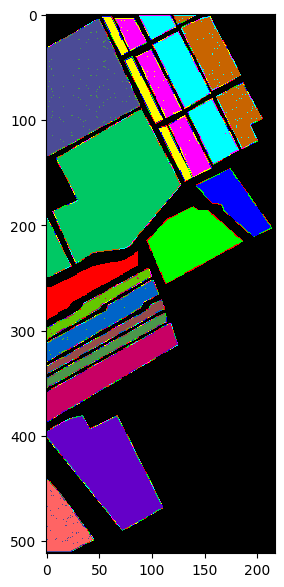

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

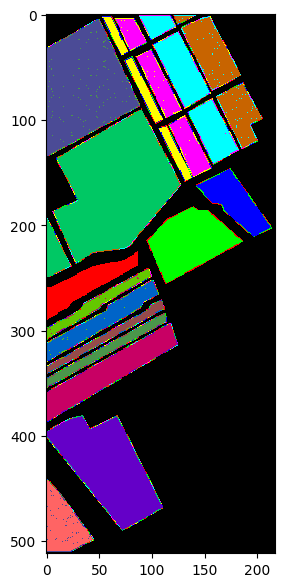

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions2.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)